Loaded via ucimlrepo (id=296)

Data summary
Train size: (40000, 58) Test size: (10000, 58)
Positive rate (train): 0.11175 Positive rate (test): 0.1117

Alpha (Linear) | Bal. Acc   | F1        
------------------------------------------
0.0            | 0.6001     | 0.2567    
0.1            | 0.6005     | 0.2572    
0.2            | 0.6015     | 0.2579    
0.3            | 0.6016     | 0.2578    
0.4            | 0.6018     | 0.2579    
0.5            | 0.6023     | 0.2585    
0.6            | 0.6044     | 0.2605    
0.7            | 0.6060     | 0.2621    
0.8            | 0.6056     | 0.2621    
0.9            | 0.6051     | 0.2624    
1.0            | 0.5952     | 0.2557    


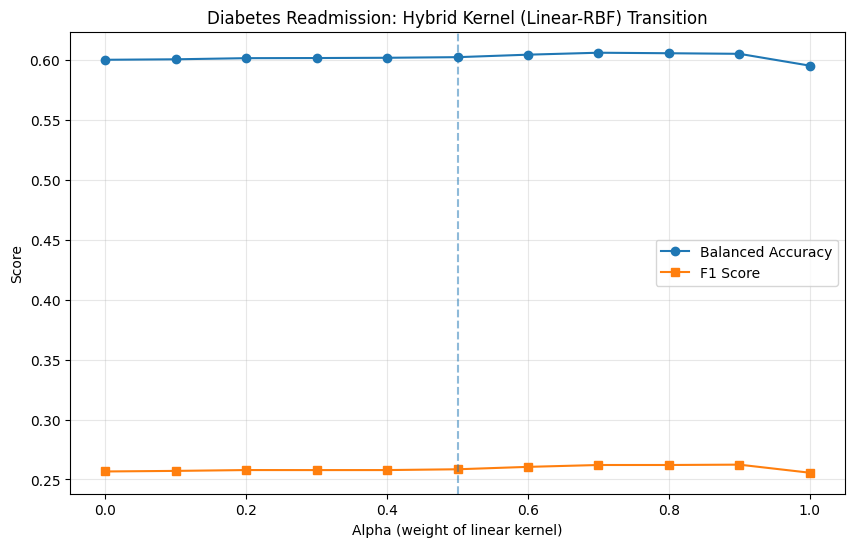


Best by balanced accuracy: (0.7000000000000001, 0.6060159775278159, 0.26208766380478987)


In [2]:
import os
import zipfile
import urllib.request
import subprocess
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics.pairwise import rbf_kernel

warnings.filterwarnings("ignore")
RANDOM_STATE = 42


# ----------------------------
# 1) Load dataset robustly
# ----------------------------
def load_diabetes_df():
    """
    Tries (in order):
    1) local diabetic_data.csv
    2) ucimlrepo (id=296)
    3) download zip from UCI and extract diabetic_data.csv
    Returns a pandas DataFrame.
    """
    local_path = "diabetic_data.csv"
    if os.path.exists(local_path):
        print("Loaded local file: diabetic_data.csv")
        return pd.read_csv(local_path, na_values=["?"])

    # Try ucimlrepo
    try:
        import ucimlrepo  # noqa
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "ucimlrepo"])
        except Exception as e:
            print("Could not install ucimlrepo:", e)

    try:
        from ucimlrepo import fetch_ucirepo

        ds = fetch_ucirepo(id=296)
        df = ds.data.original.copy()
        print("Loaded via ucimlrepo (id=296)")
        return df
    except Exception as e:
        print("ucimlrepo load failed:", e)

    # Download zip and extract
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
    zip_path = "dataset_diabetes.zip"
    print("Downloading from UCI...")
    urllib.request.urlretrieve(url, zip_path)

    with zipfile.ZipFile(zip_path, "r") as z:
        members = z.namelist()
        # the CSV is typically named 'diabetic_data.csv'
        csv_name = None
        for m in members:
            if m.lower().endswith("diabetic_data.csv"):
                csv_name = m
                break
        if csv_name is None:
            raise FileNotFoundError("Could not find diabetic_data.csv inside the downloaded zip.")

        z.extract(csv_name, ".")
        # In case it extracted into a folder, read from that exact path
        extracted_path = csv_name

    print("Loaded from downloaded zip:", extracted_path)
    df = pd.read_csv(extracted_path, na_values=["?"])
    return df


df = load_diabetes_df()

# Make missing-value handling consistent even if df came from ucimlrepo
df = df.replace("?", np.nan)


# ----------------------------
# 2) Clean + feature engineering (no feature explosion)
# ----------------------------
# Drop columns that are often missing or not useful for prediction
drop_cols = ["weight", "payer_code", "medical_specialty", "encounter_id", "patient_nbr"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Target: readmitted < 30 days vs all other outcomes
df = df.dropna(subset=["readmitted"])
df["readmitted"] = (df["readmitted"] == "<30").astype(int)

# Fill missing values safely instead of dropping tons of rows
cat_small = ["race", "gender", "age", "max_glu_serum", "A1Cresult"]
for c in cat_small:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# Medication-like columns: encode ordinally to avoid one-hot explosion
# Common values: 'No', 'Steady', 'Up', 'Down'
med_map = {"No": 0, "Steady": 1, "Up": 2, "Down": 3}
med_like_cols = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
    "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
    "examide", "citoglipton", "insulin", "glyburide-metformin",
    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone",
    "metformin-pioglitazone", "change", "diabetesMed"
]
for c in med_like_cols:
    if c in df.columns:
        df[c] = df[c].map(med_map).fillna(0).astype(int)

# Keep a controlled set of numeric predictors (plus we will add small one-hots)
# These columns exist in the dataset and are generally informative.
numeric_core = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications",
    "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses",
    "admission_type_id", "discharge_disposition_id", "admission_source_id",
]
numeric_core = [c for c in numeric_core if c in df.columns]

# One-hot encode only low-cardinality categorical columns (small list above)
df_ohe = pd.get_dummies(df, columns=[c for c in cat_small if c in df.columns], drop_first=True)

# Build final feature frame:
keep_cols = numeric_core + [c for c in med_like_cols if c in df_ohe.columns]
# Add the created one-hot columns
keep_cols += [c for c in df_ohe.columns if any(c.startswith(k + "_") for k in cat_small)]
keep_cols = list(dict.fromkeys(keep_cols))  # unique, preserve order

X_df = df_ohe[keep_cols].copy()
y = df_ohe["readmitted"].values

# Replace any remaining NaNs in features
X_df = X_df.fillna(0)

# Optional: sample to keep kernel SVM stable in memory/time
N = min(50000, len(X_df))
df_sample = X_df.sample(n=N, random_state=RANDOM_STATE)
y_sample = df_ohe.loc[df_sample.index, "readmitted"].values

X = df_sample.values.astype(np.float32)


# ----------------------------
# 3) Train/test split + standardize
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_sample, test_size=0.2, stratify=y_sample, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

print("\nData summary")
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Positive rate (train):", float(y_train.mean()), "Positive rate (test):", float(y_test.mean()))


# ----------------------------
# 4) Precompute kernels once (fast) + proper normalization
# ----------------------------
def normalized_linear_kernels(X_tr, X_te):
    """
    Cosine-normalized linear kernel:
    K(x,z) = (x·z)/(|x||z|)
    This makes diag(K_train)=1 and gives a meaningful mix with RBF.
    """
    K_tr = X_tr @ X_tr.T
    K_te = X_te @ X_tr.T

    tr_norm2 = np.sum(X_tr * X_tr, axis=1)  # shape (n_tr,)
    te_norm2 = np.sum(X_te * X_te, axis=1)  # shape (n_te,)

    # avoid divide by zero
    tr_norm2 = np.maximum(tr_norm2, 1e-12)
    te_norm2 = np.maximum(te_norm2, 1e-12)

    K_tr /= np.sqrt(np.outer(tr_norm2, tr_norm2))
    K_te /= np.sqrt(np.outer(te_norm2, tr_norm2))
    return K_tr.astype(np.float32), K_te.astype(np.float32)


gamma = 1.0 / X_train.shape[1]  # your original heuristic

K_lin_tr, K_lin_te = normalized_linear_kernels(X_train, X_test)
K_rbf_tr = rbf_kernel(X_train, X_train, gamma=gamma).astype(np.float32)
K_rbf_te = rbf_kernel(X_test, X_train, gamma=gamma).astype(np.float32)


# ----------------------------
# 5) Evaluate hybrid kernel efficiently
# ----------------------------
def evaluate_alpha(alpha):
    K_train = alpha * K_lin_tr + (1.0 - alpha) * K_rbf_tr
    K_test = alpha * K_lin_te + (1.0 - alpha) * K_rbf_te

    clf = SVC(kernel="precomputed", class_weight="balanced", C=1.0, random_state=RANDOM_STATE)
    clf.fit(K_train, y_train)
    preds = clf.predict(K_test)

    return balanced_accuracy_score(y_test, preds), f1_score(y_test, preds)


alphas = np.linspace(0, 1, 11)
results = []

print(f"\n{'Alpha (Linear)':<14} | {'Bal. Acc':<10} | {'F1':<10}")
print("-" * 42)

for a in alphas:
    bacc, f1 = evaluate_alpha(float(a))
    results.append((float(a), float(bacc), float(f1)))
    print(f"{a:<14.1f} | {bacc:<10.4f} | {f1:<10.4f}")


# ----------------------------
# 6) Plot
# ----------------------------
alphas_list, acc_list, f1_list = zip(*results)

plt.figure(figsize=(10, 6))
plt.plot(alphas_list, acc_list, marker="o", label="Balanced Accuracy")
plt.plot(alphas_list, f1_list, marker="s", label="F1 Score")
plt.axvline(x=0.5, linestyle="--", alpha=0.5)
plt.title("Diabetes Readmission: Hybrid Kernel (Linear-RBF) Transition")
plt.xlabel("Alpha (weight of linear kernel)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

best = max(results, key=lambda t: t[1])  # best by balanced accuracy
print("\nBest by balanced accuracy:", best)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# ----------------------------
# 7) SVM Linearity Check
# ----------------------------
def svm_linearity_check(X, y):
    """
    Quick check if data is (almost) linearly separable.
    Uses a very large C in LinearSVC to try to perfectly fit.
    Prints training F1 score.
    """
    classes = np.unique(y)
    avg = "binary" if len(classes) == 2 else "macro"
    scorer = make_scorer(f1_score, average=avg)

    # Stratified 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # 1) Check linear separability on training data
    sep_test = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1e6, dual="auto", max_iter=20000, random_state=RANDOM_STATE))
    ])
    sep_test.fit(X, y)
    preds = sep_test.predict(X)
    f1_train = f1_score(y, preds, average=avg)
    print(f"\nLinear SVM Train F1 (very large C): {f1_train:.4f}")

    # Optionally, do CV for more robust check
    cv_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        clf = LinearSVC(C=1e6, dual="auto", max_iter=20000, random_state=RANDOM_STATE)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred, average=avg))
    print(f"Linear SVM 5-fold CV F1 scores: {cv_scores}")
    print(f"Mean CV F1: {np.mean(cv_scores):.4f}")

# ----------------------------
# 8) Run linearity check
# ----------------------------
svm_linearity_check(X_train, y_train)



Linear SVM Train F1 (very large C): 0.0124
Linear SVM 5-fold CV F1 scores: [0.013230429988974642, 0.01327433628318584, 0.019845644983461964, 0.011049723756906077, 0.006659267480577136]
Mean CV F1: 0.0128
